In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import squidpy as sq
from sklearn.preprocessing import StandardScaler
# from sklearn import model_selection
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
# from scipy.spatial import cKDTree
# import nichepca as npc
# from xgboost import XGBRegressor
# import gensim
# from gensim.models import word2vec
# import wandb
# from utils import find_closest_points



/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/mini/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/mini/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/mini/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/mini/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(ms

In [2]:
#Set path to data
# path_msi = "/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/V11L12-038_A1.MSI_MOSCOT_paired_hvg.h5ad"
path_msi = "/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/MSI_concat_neurotransmitters.h5ad"
path_rna = "/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/V11L12-038_A1.RNA_MOSCOT_paired_hvg.h5ad"



In [3]:
sc.read_h5ad(path_msi)

AnnData object with n_obs × n_vars = 2681 × 500
    obs: 'technology', 'clusters', 'split', 'og_index'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [4]:
adata_msi_full = sc.read_h5ad(path_msi)
adata_rna_full = sc.read_h5ad(path_rna)

### Prepare MSI data

In [5]:
adata_msi_full

AnnData object with n_obs × n_vars = 2681 × 500
    obs: 'technology', 'clusters', 'split', 'og_index'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

Here you can subset metabolites for noise  
e.g.:  
Remove m/z below FMP10, because most likely this is noise:  
```python
adata_msi_full.var_names  
adata_msi = adata_msi[:, adata_msi.var_names.astype(float) > 288.15].copy()

In [6]:
adata_msi = adata_msi_full.copy()

Quality control

In [7]:
sc.pp.calculate_qc_metrics(adata_msi, inplace=True)

<Axes: xlabel='total_counts', ylabel='Count'>

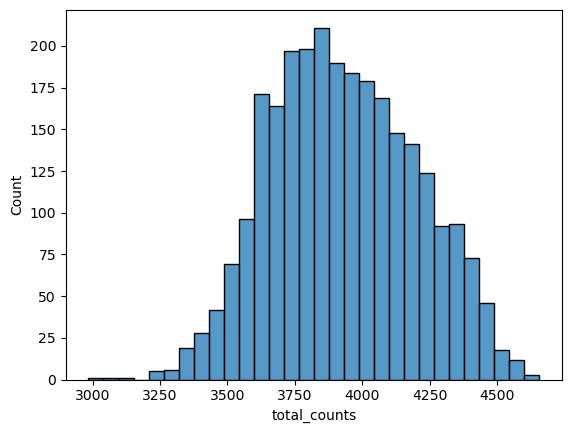

In [8]:
sns.histplot(adata_msi.obs.total_counts) #This sums all the metabolites m/z ratios for each cell

In [9]:
adata_msi.var

,highly_variable,means,dispersions,dispersions_norm,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
137.023795,True,16.457432,16.244787,1.111899,2681,16.832302,2.881012,0.000000,45127.400895,10.717267
154.026815,True,12.282051,12.890668,1.498388,2681,12.553079,2.606614,0.000000,33654.804196,10.423941
162.11293999999998,True,13.661283,13.783248,0.685038,2681,14.171650,2.719429,0.000000,37994.192488,10.545215
169.07619,True,13.470905,15.882873,5.257481,2681,13.721671,2.689321,0.000000,36787.800027,10.512949
169.076575,True,13.558031,15.862571,5.213268,2681,13.783150,2.693488,0.000000,36952.624199,10.517419
...,...,...,...,...,...,...,...,...,...,...
981.582135,True,8.348629,11.216965,0.650746,325,1.302877,0.834159,87.877658,3493.014565,8.158807
982.519885,True,8.086034,11.228839,0.684927,307,1.200151,0.788526,88.549049,3217.605359,8.076703
983.879985,True,8.370474,11.189914,0.572880,332,1.320715,0.841875,87.616561,3540.836599,8.172401
985.53971,True,7.986569,11.179927,0.625368,289,1.124553,0.753561,89.220440,3014.926453,8.011662


<Axes: xlabel='n_cells_by_counts', ylabel='Count'>

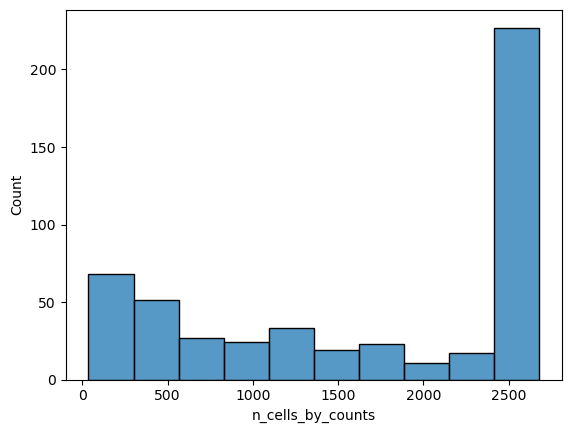

In [10]:
sns.histplot(adata_msi.var.n_cells_by_counts) #This sums all the cells for each metabolite m/z ratio
# we notice that o

In [11]:
adata_msi.var.n_cells_by_counts.describe()

count     500.00000
mean     1689.78800
std      1009.05623
min        36.00000
25%       634.50000
50%      1996.50000
75%      2678.00000
max      2681.00000
Name: n_cells_by_counts, dtype: float64

### Let's identify most spatialy variable metabolites

In [12]:
adata_msi

AnnData object with n_obs × n_vars = 2681 × 500
    obs: 'technology', 'clusters', 'split', 'og_index', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

MoranI already present, but just for completeness let's go for the procedure from beginning



In [13]:
# Identify top 5 most spatially variable metabolomes using Moran's I
sq.gr.spatial_neighbors(adata_msi, spatial_key='spatial_warp')
sq.gr.spatial_autocorr(adata_msi)


In [14]:
adata_msi

AnnData object with n_obs × n_vars = 2681 × 500
    obs: 'technology', 'clusters', 'split', 'og_index', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

Double sorting, first with index then for bh correction


In [15]:
top_20_spat = adata_msi.uns["moranI"].loc[adata_msi.uns["moranI"].pval_norm_fdr_bh < 0.05].sort_values(by=["I", "pval_norm_fdr_bh"], ascending=[False, True]).index[:10]


In [16]:
mz_values = adata_msi.var_names.astype(float).to_numpy()
mz_values
dhb_peaks_positive = np.array([137.0238, 155.0341, 177.0173, 193.0351, 273.0454])
found_peaks = set(mz_values[np.abs(mz_values[:, None] - dhb_peaks_positive[None, :]).min(axis=1) <= 0.1])
found_peaks_str = set(map(str, found_peaks))


In [17]:
found_peaks

{np.float64(137.023795),
 np.float64(177.01202),
 np.float64(273.03447),
 np.float64(273.03932)}

In [18]:
top_20_spat_filtered = [mz for mz in top_20_spat if mz not in found_peaks_str]
top_20_spat_filtered

['203.05299000000002',
 '162.11293999999998',
 '214.01164',
 '280.092375',
 '845.51016',
 '251.9674',
 '353.023935',
 '251.96654999999998',
 '617.9799350000001',
 '297.070615']

In [ ]:
['203.05299000000002',
 '162.11293999999998',
 '214.01164',
 '280.092375',
 '845.51016',
 '251.9674',
 '353.023935',
 '251.96654999999998',
 '617.9799350000001',
 '297.070615']

In [19]:
top_5_spat_metabolites = top_20_spat_filtered[:5]
adata_msi_top5_spat = adata_msi[:, adata_msi.var_names.isin(top_5_spat_metabolites)].copy()



In [56]:
adata_msi_top5_spat

AnnData object with n_obs × n_vars = 2681 × 5
    obs: 'technology', 'clusters', 'split', 'og_index', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [ ]:
# adata_msi_top10_spat.write("/lustre/groups/ml01/workspace/eirini.giannakoulia/msi_ds/V11L12-038_A1.MSI_MOSCOT_paired_hvg_top10spatvar.h5ad")
# adata_msi_top20_spat.write("/lustre/groups/ml01/workspace/eirini.giannakoulia/msi_ds/V11L12-038_A1.MSI_MOSCOT_paired_hvg_top20spatvar.h5ad")
adata_msi_top5_spat.write("/lustre/groups/ml01/workspace/eirini.giannakoulia/msi_ds/MSI_concat_neuro_top5spatvar.h5ad")